# Project 2 Group 4

In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report

In [554]:
import requests
from dotenv import load_dotenv
import os
import json
import time

In [555]:
# Set environment variables from the .env in the local environment
load_dotenv()
epa_api_key = os.getenv("EPA_API_KEY")
email = os.getenv("EMAIL")

# AQS EPA data for New York Metroplolitan Area 
Data for years: 2013-2023  
New York State Code: 36  
County codes used:    
005	Bronx County  
047	Kings County  
061	New York County  
081	Queens County  
085	Richmond County  

### Parameter Codes used:  
42101 - Carbon monoxide  (has data)  
44201 - Ozone  (has data)  
88101 - PM2.5  (has data)  

81102 - PM10  (no data)    
42401 - Sulfer Dioxide  (no data)  
42602 - Nitrogen Dioxide  (no data)  
88502 - Acceptable PM2.5 AQI & Speciation Mass (has data but dropna removes all records)  


In [895]:
# Define the API endpoint and parameters
url = "https://aqs.epa.gov/data/api/dailyData/byCounty?"
# https://aqs.epa.gov/data/api/dailyData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37
#url = "https://aqs.epa.gov/data/api/dailyData/byState?"
param = "44201"         #44201,42101,88101,81102,42401,42602"
begin_date = "20230101"
end_date = "20231231"
state = "36"           
county = "061"         #New York County

# Build URL
"""
query_url = (
    f"{url}email={email}&key={epa_api_key}&param={param}&bdate={begin_date}&edate={end_date}"
    + f"&state={state}"
)
"""
query_url = (
    f"{url}email={email}&key={epa_api_key}&param={param}&bdate={begin_date}&edate={end_date}"
    + f"&state={state}&county={county}"
)


In [896]:
# Make the API request
response = requests.get(query_url).json()

json.dumps(response, indent=4)
response_df = pd.json_normalize(response["Data"])
#response_df.sort_values(by='date_local',inplace=True)
print(f"Shape = {response_df.shape}")
response_df.head()

Shape = (1460, 32)


,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,36,061,0135,44201,1,40.81976,-73.94825,WGS84,Ozone,1,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,CCNY,160 CONVENT AVENUE,New York,New York,New York,35620,"New York-Newark-Jersey City, NY-NJ-PA",2024-05-24
1,36,061,0135,44201,1,40.81976,-73.94825,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,CCNY,160 CONVENT AVENUE,New York,New York,New York,35620,"New York-Newark-Jersey City, NY-NJ-PA",2024-05-25
2,36,061,0135,44201,1,40.81976,-73.94825,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,CCNY,160 CONVENT AVENUE,New York,New York,New York,35620,"New York-Newark-Jersey City, NY-NJ-PA",2024-05-25
3,36,061,0135,44201,1,40.81976,-73.94825,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,CCNY,160 CONVENT AVENUE,New York,New York,New York,35620,"New York-Newark-Jersey City, NY-NJ-PA",2024-05-25
4,36,061,0135,44201,1,40.81976,-73.94825,WGS84,Ozone,1,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,CCNY,160 CONVENT AVENUE,New York,New York,New York,35620,"New York-Newark-Jersey City, NY-NJ-PA",2024-05-24


In [897]:
response_df.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'pollutant_standard', 'date_local',
       'units_of_measure', 'event_type', 'observation_count',
       'observation_percent', 'validity_indicator', 'arithmetic_mean',
       'first_max_value', 'first_max_hour', 'aqi', 'method_code', 'method',
       'local_site_name', 'site_address', 'state', 'county', 'city',
       'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

In [898]:
response_df.to_csv("Resources/ny_state_aqi_data_2013.csv", index=False)

In [899]:
print(response_df['county_code'].value_counts())

county_code
061    1460
Name: count, dtype: int64


In [900]:
#print(response_df['observation_count'].value_counts() )

In [901]:
test_selected_df = response_df[['county_code', 'parameter_code', 'latitude', 'longitude', 'validity_indicator', 'sample_duration_code',
       'pollutant_standard', 'date_local',
       'units_of_measure', 'observation_count',
       'arithmetic_mean',
       'aqi', 'city']]
test_selected_df.head(20)

,county_code,parameter_code,latitude,longitude,validity_indicator,sample_duration_code,pollutant_standard,date_local,units_of_measure,observation_count,arithmetic_mean,aqi,city
0,061,44201,40.81976,-73.94825,Y,1,Ozone 1-hour 1979,2023-01-01,Parts per million,24,0.015042,NaN,New York
1,061,44201,40.81976,-73.94825,Y,W,Ozone 8-Hour 1997,2023-01-01,Parts per million,24,0.014917,26.0,New York
2,061,44201,40.81976,-73.94825,Y,W,Ozone 8-Hour 2008,2023-01-01,Parts per million,24,0.014917,26.0,New York
3,061,44201,40.81976,-73.94825,Y,W,Ozone 8-hour 2015,2023-01-01,Parts per million,17,0.015353,26.0,New York
4,061,44201,40.81976,-73.94825,Y,1,Ozone 1-hour 1979,2023-01-02,Parts per million,24,0.005000,NaN,New York
5,061,44201,40.81976,-73.94825,Y,W,Ozone 8-Hour 1997,2023-01-02,Parts per million,24,0.003958,8.0,New York
6,061,44201,40.81976,-73.94825,Y,W,Ozone 8-Hour 2008,2023-01-02,Parts per million,24,0.003958,8.0,New York
7,061,44201,40.81976,-73.94825,Y,W,Ozone 8-hour 2015,2023-01-02,Parts per million,17,0.004000,8.0,New York
8,061,44201,40.81976,-73.94825,Y,1,Ozone 1-hour 1979,2023-01-03,Parts per million,24,0.000083,NaN,New York
9,061,44201,40.81976,-73.94825,Y,W,Ozone 8-Hour 1997,2023-01-03,Parts per million,24,0.000000,0.0,New York


In [902]:
test_selected_df = test_selected_df.dropna()

In [903]:
# print(test_selected_df['sample_duration_code'].value_counts())

In [904]:
test_selected_df.shape

(1095, 13)

API call for entire NY state  

Data for Counties:  
103 Suffolk (LI),  
005 Bronx,  
061 NYC,  
081 Queens  
085 Richmond  

Pollution Parameters:  
[42101, 44201 , 88101, 81102, 42401, 42602]  


In [931]:
# List of columns name for data extraction
columns_to_select = ['county_code', 'parameter_code', 'latitude', 'longitude', 'validity_indicator', 'sample_duration_code',
       'pollutant_standard', 'date_local',
       'units_of_measure', 'observation_count',
       'arithmetic_mean',
       'aqi', 'city']
"""
[ 'parameter_code', 'sample_duration_code', 'sample_duration',
                      'date_local', 'observation_count',
                      'observation_percent', 'arithmetic_mean', 'aqi',
                      'latitude', 'longitude', 'city']
"""                      
state = "36" 
#county = "061"
county_list = ['005', '061', '081']
"""
005 Bronx County
061 New York County
081 Queens County

059 Nassau county
103 Suffolk county (Long Island)

047 Kings County
085 Richmond County
"""
years_list = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
# List of parameter codes
parameter_codes = [42101, 44201, 88101] #[42101, 44201] #, 88101, 81102, 42401, 42602]  

In [932]:
# Function to make API call and return selected columns as DataFrame
def get_data_for_parameter(parameter_code):
    # Build URL
    query_url = (f"{url}email={email}&key={epa_api_key}&param={parameter_code}&bdate={begin_date}&edate={end_date}"
               + f"&state={state}&county={county}" )


    
    param_data = requests.get(query_url).json()
    #Add 2 second wait step
    time.sleep(2)
    #param_data.raise_for_status()  # Raise an error for bad status codes
    json.dumps(param_data, indent=4)
    # Convert data into DataFrame
    param_df = pd.json_normalize(param_data["Data"])
    # Sort by Dates
    param_df.sort_values(by='date_local',inplace=True)
    # Return data frame that has only selected ciolumns
    selected_df = param_df[columns_to_select]

    print(begin_date, end_date, parameter_code)

    return selected_df

In [933]:
# Initialize an empty DataFrame to hold the final merged data
#merged_df = pd.DataFrame()
for county_index, county in enumerate(county_list):
    for yrs_index, year in enumerate (years_list):
        begin_date = str(year) + "0101"
        end_date = str(year) + "1231"
        
        # Loop through the parameter codes, get data, and merge
        for index, code in enumerate (parameter_codes):
            
            param_df = get_data_for_parameter(code)  #.set_index("date_local")
            param_df = param_df.dropna()             

            aggregated_df = param_df.groupby('date_local').agg({
                                       'county_code': 'first',
                                       'parameter_code': 'first', 
                                       'latitude': 'first',
                                       'longitude': 'first',
                                       'validity_indicator': 'first',
                                       'sample_duration_code': 'first',  
                                       #'sample_duration': 'first',
                                       'pollutant_standard': 'first',
                                       'units_of_measure': 'first',
                                       'observation_count': 'sum',
                                       #'observation_percent': 'mean',    
                                       'arithmetic_mean': 'mean',
                                       'aqi': 'mean',
                                       'city': 'first'
                                }).reset_index()
            
            aggregated_df = aggregated_df.set_index("date_local")
            
            if index == 0:
                joined_df = aggregated_df # param_df
                #print(f"Param index = {index}")
                #print(f"Joined_DF shape {joined_df.shape}")
                
            else:
                
                #joined_df = joined_df.join(aggregated_df, rsuffix=code)
                joined_df = joined_df.join(aggregated_df, on="date_local", how="outer",rsuffix=code)
                #pd.merge(joined_df, aggregated_df, how='outer', on='date_local')
                #joined_df = pd.concat([joined_df, aggregated_df], axis=1, join="outer")
                #joined_df = joined_df.merge(aggregated_df, left_index=True, right_index=True, how='outer', suffixes=('_1', code))
                #print(f"Param else index = {index}")
                #print(f"Joined_DF shape {joined_df.shape}")
            
    if yrs_index == 0:          
        merged_df = joined_df
            #print(f"Years index = {yrs_index}")
            #print(f"merged_DF shape {merged_df.shape}")
    else:   
        merged_df = pd.concat([merged_df, joined_df], axis='rows', join="outer")
            #print(f"Years else index = {yrs_index}")
            #print(f"merged_DF shape {merged_df.shape}")
     
    if county_index == 0:
        all_counties_df = merged_df
    else:
        all_counties_df = pd.concat([all_counties_df, merged_df], axis='rows', join='outer')
    
#merged_df.reset_index()
#all_counties_df

# Display merged DataFrame
#merged_df.head(20)
all_counties_df.head(20)


20130101 20131231 42101
20130101 20131231 44201
20130101 20131231 88101
20140101 20141231 42101
20140101 20141231 44201
20140101 20141231 88101
20150101 20151231 42101
20150101 20151231 44201
20150101 20151231 88101
20160101 20161231 42101
20160101 20161231 44201
20160101 20161231 88101
20170101 20171231 42101
20170101 20171231 44201
20170101 20171231 88101
20180101 20181231 42101
20180101 20181231 44201
20180101 20181231 88101
20190101 20191231 42101
20190101 20191231 44201
20190101 20191231 88101
20200101 20201231 42101
20200101 20201231 44201
20200101 20201231 88101
20210101 20211231 42101
20210101 20211231 44201
20210101 20211231 88101
20220101 20221231 42101
20220101 20221231 44201
20220101 20221231 88101
20230101 20231231 42101
20230101 20231231 44201
20230101 20231231 88101
20240101 20241231 42101
20240101 20241231 44201
20240101 20241231 88101
20130101 20131231 42101
20130101 20131231 44201
20130101 20131231 88101
20140101 20141231 42101
20140101 20141231 44201
20140101 2014123

,parameter_code,sample_duration_code,sample_duration,observation_count,observation_percent,arithmetic_mean,aqi,parameter_code44201,sample_duration_code44201,sample_duration44201,...,city44201,latitude88101,longitude88101,validity_indicator88101,pollutant_standard88101,units_of_measure88101,city88101,county_code,county_code44201,county_code88101
date_local,,,,,,,,,,,,,,,,,,,,,
2013-01-01,42101,Z,8-HR RUN AVG END HOUR,19.0,79.0,0.300000,3.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.400000,6.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.437500,6.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.395833,6.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.275000,3.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-06,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.279167,5.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.179167,3.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.408333,6.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.641667,11.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [934]:
all_counties_df.tail()

,parameter_code,sample_duration_code,sample_duration,observation_count,observation_percent,arithmetic_mean,aqi,parameter_code44201,sample_duration_code44201,sample_duration44201,...,city44201,latitude88101,longitude88101,validity_indicator88101,pollutant_standard88101,units_of_measure88101,city88101,county_code,county_code44201,county_code88101
date_local,,,,,,,,,,,,,,,,,,,,,
2024-03-28,42101,Z,NaN,24.0,NaN,0.570833,9.0,44201,W,NaN,...,New York,40.739264,-73.817694,Y,PM25 Annual 1997,Micrograms/cubic meter (LC),New York,081,081,081
2024-03-29,42101,Z,NaN,24.0,NaN,0.212500,3.0,44201,W,NaN,...,New York,40.736140,-73.821530,Y,PM25 24-hour 2006,Micrograms/cubic meter (LC),New York,081,081,081
2024-03-30,42101,Z,NaN,24.0,NaN,0.204167,3.0,44201,W,NaN,...,New York,40.736140,-73.821530,Y,PM25 24-hour 2006,Micrograms/cubic meter (LC),New York,081,081,081
2024-03-31,42101,Z,NaN,24.0,NaN,0.254167,3.0,44201,W,NaN,...,New York,40.736140,-73.821530,Y,PM25 Annual 2006,Micrograms/cubic meter (LC),New York,081,081,081
2024-04-01,42101,Z,NaN,2.0,NaN,0.300000,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,081,NaN,NaN


In [937]:
# Add new column for Max AQI value
all_counties_df['aqi_max'] = all_counties_df[['aqi', 'aqi44201', 'aqi88101']].max(axis=1)

In [939]:
#merged_df.dropna()
all_counties_df.shape

(14778, 43)

In [940]:
all_counties_df.columns

Index(['parameter_code', 'sample_duration_code', 'sample_duration',
       'observation_count', 'observation_percent', 'arithmetic_mean', 'aqi',
       'parameter_code44201', 'sample_duration_code44201',
       'sample_duration44201', 'observation_count44201',
       'observation_percent44201', 'arithmetic_mean44201', 'aqi44201',
       'parameter_code88101', 'sample_duration_code88101',
       'sample_duration88101', 'observation_count88101',
       'observation_percent88101', 'arithmetic_mean88101', 'aqi88101',
       'aqi_max', 'latitude', 'longitude', 'validity_indicator',
       'pollutant_standard', 'units_of_measure', 'city', 'latitude44201',
       'longitude44201', 'validity_indicator44201', 'pollutant_standard44201',
       'units_of_measure44201', 'city44201', 'latitude88101', 'longitude88101',
       'validity_indicator88101', 'pollutant_standard88101',
       'units_of_measure88101', 'city88101', 'county_code', 'county_code44201',
       'county_code88101'],
      dtype='o

In [921]:
all_counties_df.head(2)

,parameter_code,sample_duration_code,sample_duration,observation_count,observation_percent,arithmetic_mean,aqi,parameter_code44201,sample_duration_code44201,sample_duration44201,...,validity_indicator44201,pollutant_standard44201,units_of_measure44201,city44201,latitude88101,longitude88101,validity_indicator88101,pollutant_standard88101,units_of_measure88101,city88101
date_local,,,,,,,,,,,,,,,,,,,,,
2013-01-01,42101,Z,8-HR RUN AVG END HOUR,19.0,79.0,0.3,3.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,42101,Z,8-HR RUN AVG END HOUR,24.0,100.0,0.4,6.0,44201,W,8-HR RUN AVG BEGIN HOUR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [924]:
#all_counties_df.set_index("date_local", inplace=True)
print(all_counties_df.index.name)

date_local


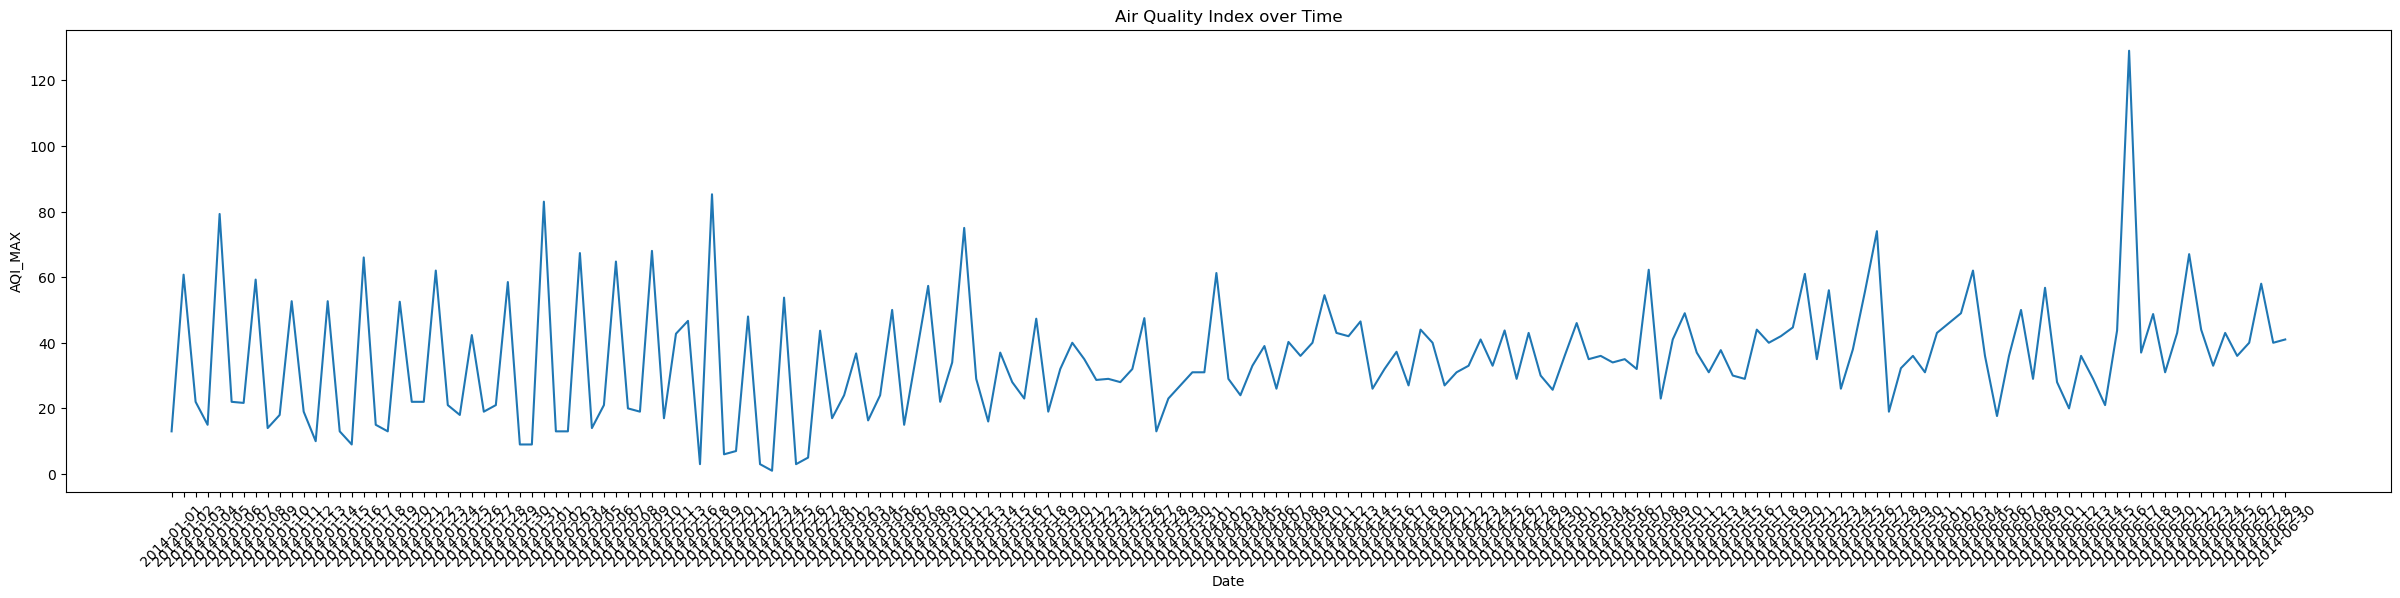

In [925]:
# Plot AQI for year 2013

partial_df = merged_df.loc['2014-01-01':'2014-06-30']
partial_df.reset_index('date_local', inplace=True)
plt.figure(figsize=(30, 6))
plt.plot(partial_df['date_local'], partial_df['aqi_max'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('AQI_MAX')
plt.title('Air Quality Index over Time')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [926]:
all_counties_df = all_counties_df.reset_index()
print(all_counties_df.index.name)

None


In [927]:
all_counties_df.to_csv("Resources/three_counties_aqi_data_2013_2024.csv", index=False)